In [153]:
%autosave 0

Autosave disabled


# Sentiment Analysis

## Start the NLP server


In [154]:
import os

STANFORD_NLP_LOCATION = '~/stanford-corenlp-full-2018-10-05/' # the location of the Stanford NLP library on my computer 
                                                              #(download at https://stanfordnlp.github.io/CoreNLP)
STANFORD_NLP_TIMEOUT = 100000 # the time after which a given NLP request will be killed if not yet complete

exec = os.popen
exec('cd {}; java -mx5g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout {}'.format(
        STANFORD_NLP_LOCATION, STANFORD_NLP_TIMEOUT)) 

## Create function to determine the sentiment of a block of text

In [32]:
from pycorenlp import StanfordCoreNLP
import numpy

MIN_SENTIMENT = 0
MAX_SENTIMENT = 4

# Determines the sentiment of a given block of text as a range from 0 (Extremely Negative) to 4 (Extremely Positive).
def findSentiment(text):
    NLP_SERVER_LOCATION = 'http://localhost:9000'
    PROPERTIES_DICTIONARY = {'annotators': 'sentiment', 'outputFormat': 'json', 'timeout': 10000}
    
    nlp = StanfordCoreNLP(NLP_SERVER_LOCATION)
    result = nlp.annotate(text, properties = PROPERTIES_DICTIONARY)

    sentiments = []
    for sentenceAnalysis in result['sentences']:
        sentimentValue = float(sentenceAnalysis['sentimentValue'])
        sentiments += [sentimentValue]
    return numpy.average(sentiments)

## Create gauge visual for sentiment reading

In [13]:
%matplotlib notebook
import os, sys
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle

ARROW_TAIL_RADIUS = 0.015

# Determines the range of angles which represent each portion of a gauge with n items.
def degreeRange(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = (start + end)/2.0
    return np.c_[start, end], mid_points

# Rotates a piece of text by a given angle.
def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

# Linearly maps a value within one range to a new range.
def map(num, init_min, init_max, new_min, new_max):
    return (num - init_min) * (new_max - new_min) / (init_max - init_min) + new_min

'''
Creates and displays a gauge. Returns a tuple with the arrow and axes used for convenient modification.
'''
def gauge(labels, colors, currentVal, minVal, maxVal, title='', fname=False): 
    N = len(labels)

    if isinstance(colors, list): 
        colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degreeRange(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels):
        AVG_STR_LENGTH = 12
        AVG_FONT_SIZE = 11
        MAX_FONT_SIZE = 30
        
        fontSize = min(AVG_STR_LENGTH / len(lab) * AVG_FONT_SIZE, MAX_FONT_SIZE) # create dynamic font size based on string length
        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab,
            horizontalalignment='center', verticalalignment='center', fontsize=fontSize,
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center',
         verticalalignment='center', fontsize=22, fontweight='bold')

    #Plot the arrow based on given sentiment value.
    lowestAngle = ang_range[0][0]
    highestAngle = ang_range[-1][1]
    
    pos = map(currentVal, minVal, maxVal, highestAngle, lowestAngle)
    
    arrow = ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
                 width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
    #arrow.remove()
    
    ax.add_patch(Circle((0, 0), radius=ARROW_TAIL_RADIUS, facecolor='k')) # make the arrow rounded at the tail

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)
    
    return (arrow, ax, fig)

## Create function for plotting any time-series data

In [186]:
def plotTimeSeries(xyDict, title="",dateFormat="%Y-%m-%dT%H:%M:%S.%fZ", graphDateFormatType="%Y"):
    fig, ax = plt.subplots()
    for valueType, xyVals in xyDict.items():
        formattedDates = []
        for date in xyVals['x']:
            if not isinstance(date, datetime.datetime):
                formattedDates += [datetime.datetime.strptime(date, dateFormat)]
            else:
                formattedDates += [date]
            
        dates = matplotlib.dates.date2num(formattedDates)

        ax.plot(formattedDates, xyVals['y'])
        ax.set_title(title)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(graphDateFormatType))

## Create function to compute and display sentiment value

In [5]:
def displaySentimentNum(sentimentVal):
    return (sentimentVal, gauge(labels=['Very Negative','Negative','Neutral','Positive', 'Very Positive'], 
      colors=['#c80000','#c84b00','#646400','#64a000', '#00c800'], currentVal=sentimentVal, minVal = MIN_SENTIMENT, maxVal = MAX_SENTIMENT, title='Cryptocurrency Sentiment'))
def displaySentimentTxt(text):
    return displaySentimentNum(findSentiment(text))    

## Scrape web for news article

The cryptocurrency has risen 148% in 2019. Many investors are betting on more growth ahead. As JPMorgan (JPM), Fidelity and the New York Stock Exchange get into the cryptocurrency business, investors have grown to trust bitcoin more as an asset for growth in their portfolios, says Kirill Bensonoff, CEO of OpenLTV, a platform which offers cryptocurrency and fiat loans for real estate debt. But as the price continues to rise,  we may see more corrections ahead,  Bensonoff said.Some bitcoin watchers anticipate the price could exceed $13,500 this year — eventually hitting an all-time high of $30,000 this year, bets Jehan Chu, co-founder and managing partner at Kenetic, a blockchain platform. Chu owns bitcoin and has repeatedly told media he anticipates bitcoin will rise to $30,000 in between steep rises and valleys. He said that low supply and increased demand, plus potential investment from established companies like Google and Apple, will fuel a price upswing.But others remain skeptical 

<IPython.core.display.Javascript object>


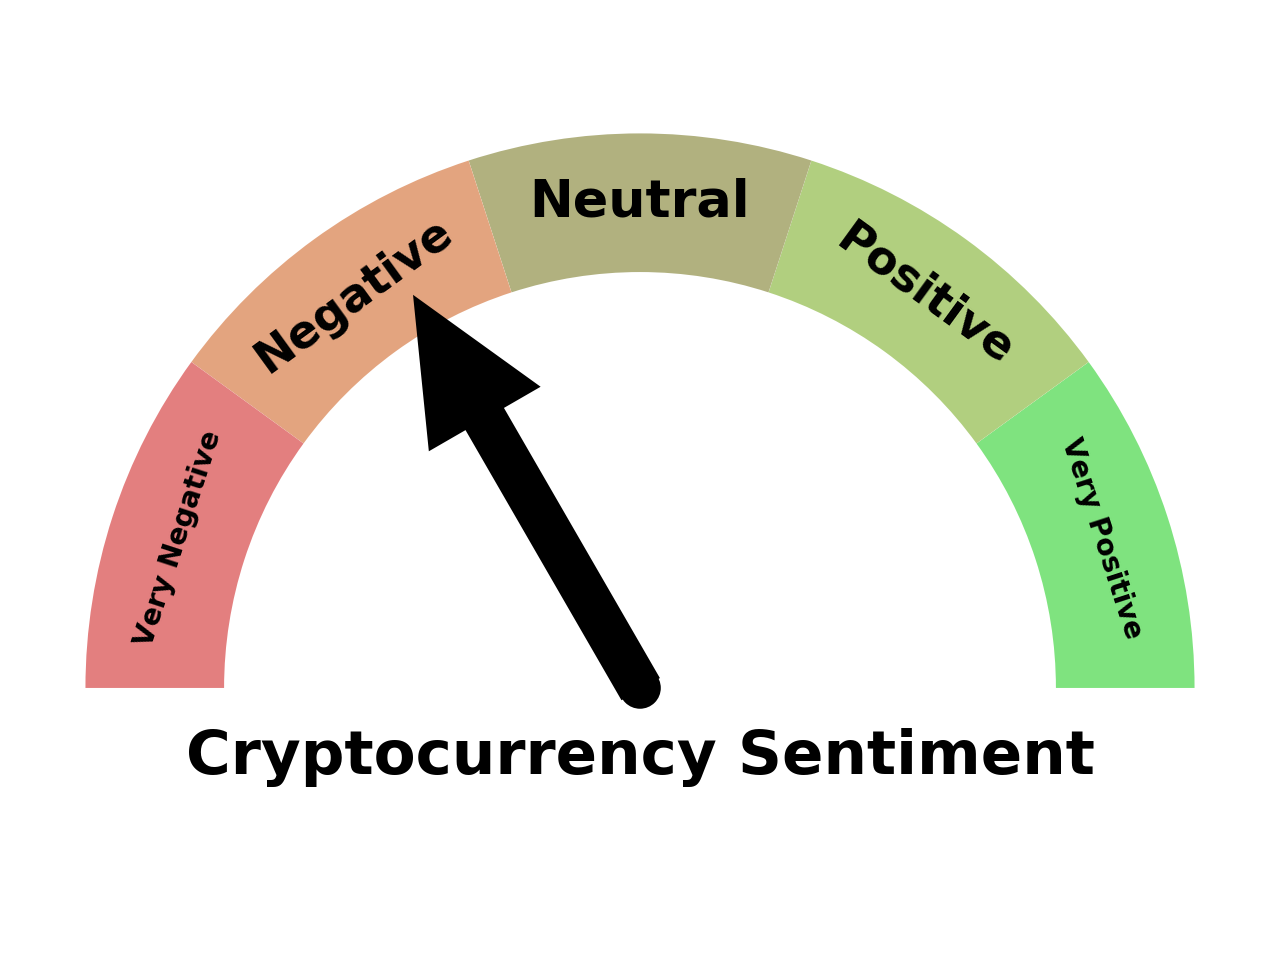

In [6]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from newsapi import NewsApiClient

def getPageContent(url):
    try: 
        with closing(get(url, stream = True)) as page:
            return page.content.decode("utf-8")
    except RequestException as e:
        print(e)
        return
    
def parseHTML(url):
    return BeautifulSoup(getPageContent(url), 'html.parser')

# Extracts the text from a CNN article with given URL, excluding the headline and any advertisements.
def getCNNText(url):
    htmlParser = parseHTML(url)
    
    text = ''

    for element in htmlParser.select('div'):
        if element.has_attr('class') and 'zn-body__paragraph' in element['class']: 
            text += element.text 
    text = text.replace('"', ' ')
    return text
text = getCNNText("https://www.cnn.com/2019/06/17/investing/bitcoin-9300-trnd/index.html")
print(text)
displaySentimentTxt(text)

# Uses NewsAPI to extract all articles from a given day.
def getArticleURLs(day, month, year):
    dayPrefix = "%04d-%02d-%02d" % (year, month, day)
    
    newsapi = NewsApiClient(api_key = '8d99d69a251a453f8c084f4768db7195')
    
    urls = []
    second = 0
    minute = 0
    for hour in range (0, 24):
        for minute in range (0, 59, 10):
            iso8601DateStart = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute, second))
            iso8601DateEnd = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute + (10 if minute != 50 else 9), second))
            all_articles = newsapi.get_everything(q='bitcoin', from_param= iso8601DateStart, to=iso8601DateEnd, page=1)
            for article in all_articles['articles']:
                urls += article['url']
    return urls

## Create functions to retrieve and display Fear and Greed Index from any given date

<IPython.core.display.Javascript object>


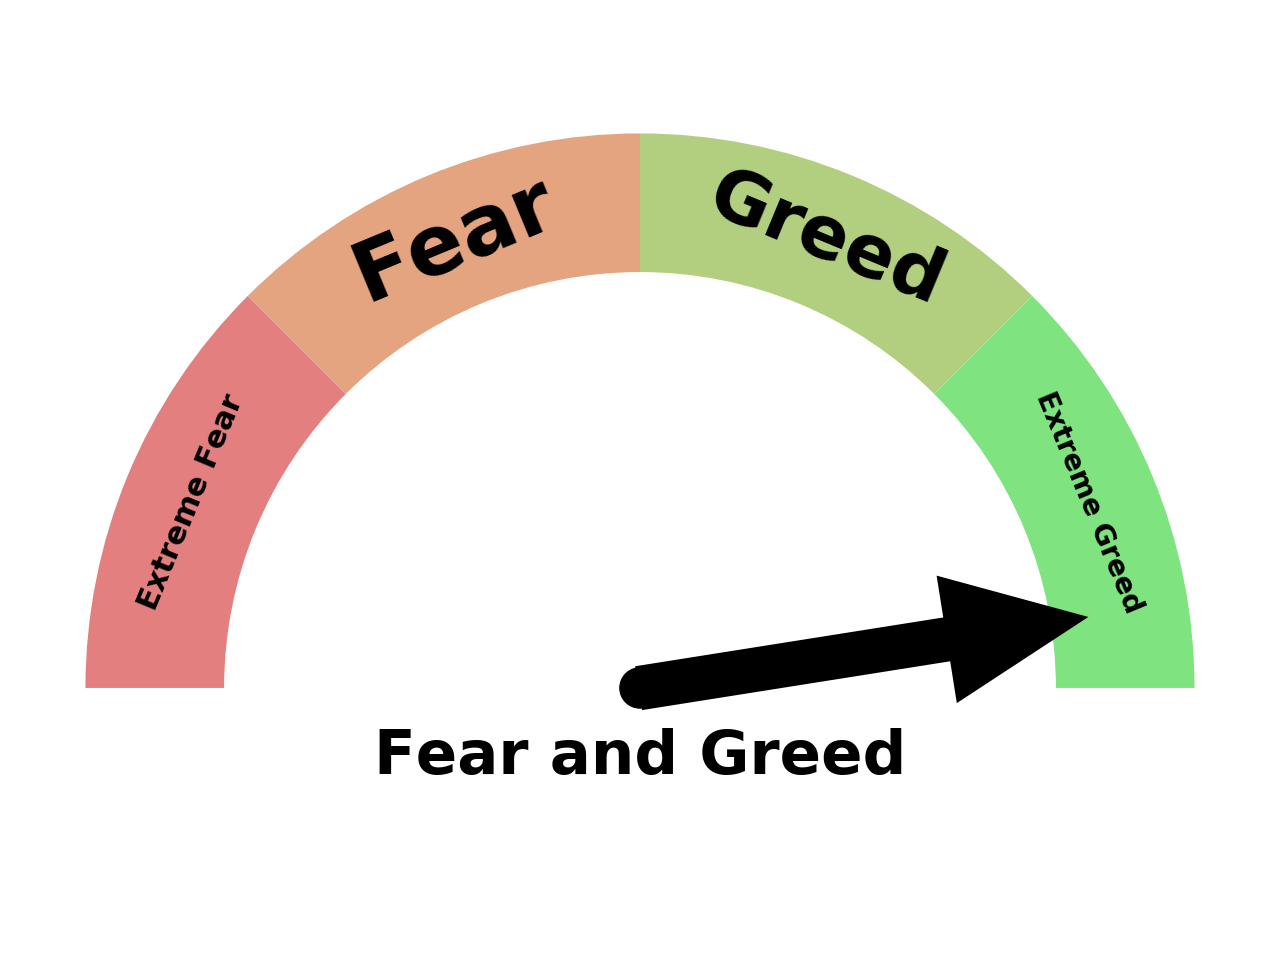

(95,
 (<matplotlib.patches.FancyArrow at 0x10b42cb70>,
  <Figure size 640x480 with 1 Axes>))

In [8]:
import json
FEAR_AND_GREED_ADDRESS = "https://api.alternative.me/fng/?limit=0&date_format=us"
    
MIN_FEAR_AND_GREED = 0
MAX_FEAR_AND_GREED = 100

def getFearAndGreed(month, day, year):
    timestampFormatted = "%02d-%02d-%04d" % (month, day, year)
    
    fearAndGreedVals = getPageContent(FEAR_AND_GREED_ADDRESS)
    jsonUnpacked = json.loads(fearAndGreedVals)
    dataArr = jsonUnpacked['data']
    
    for singleDay in dataArr:
        if singleDay['timestamp'] == timestampFormatted:
            return int(singleDay['value'])

def displayFearAndGreedNum(val):
    return (val, gauge(labels=['Extreme Fear','Fear','Greed','Extreme Greed'], 
      colors=['#c80000','#c84b00','#64a000', '#00c800'], currentVal=val, minVal = MIN_FEAR_AND_GREED,
                 maxVal = MAX_FEAR_AND_GREED, title='Fear and Greed'))
def displayFearAndGreedDate(month, day, year):
    return displayFearAndGreedNum(getFearAndGreed(month, day, year))

displayFearAndGreedDate(6, 26, 2019)

## Retrieve Google Trends data

The request failed: Google returned a response with code 500.


<IPython.core.display.Javascript object>


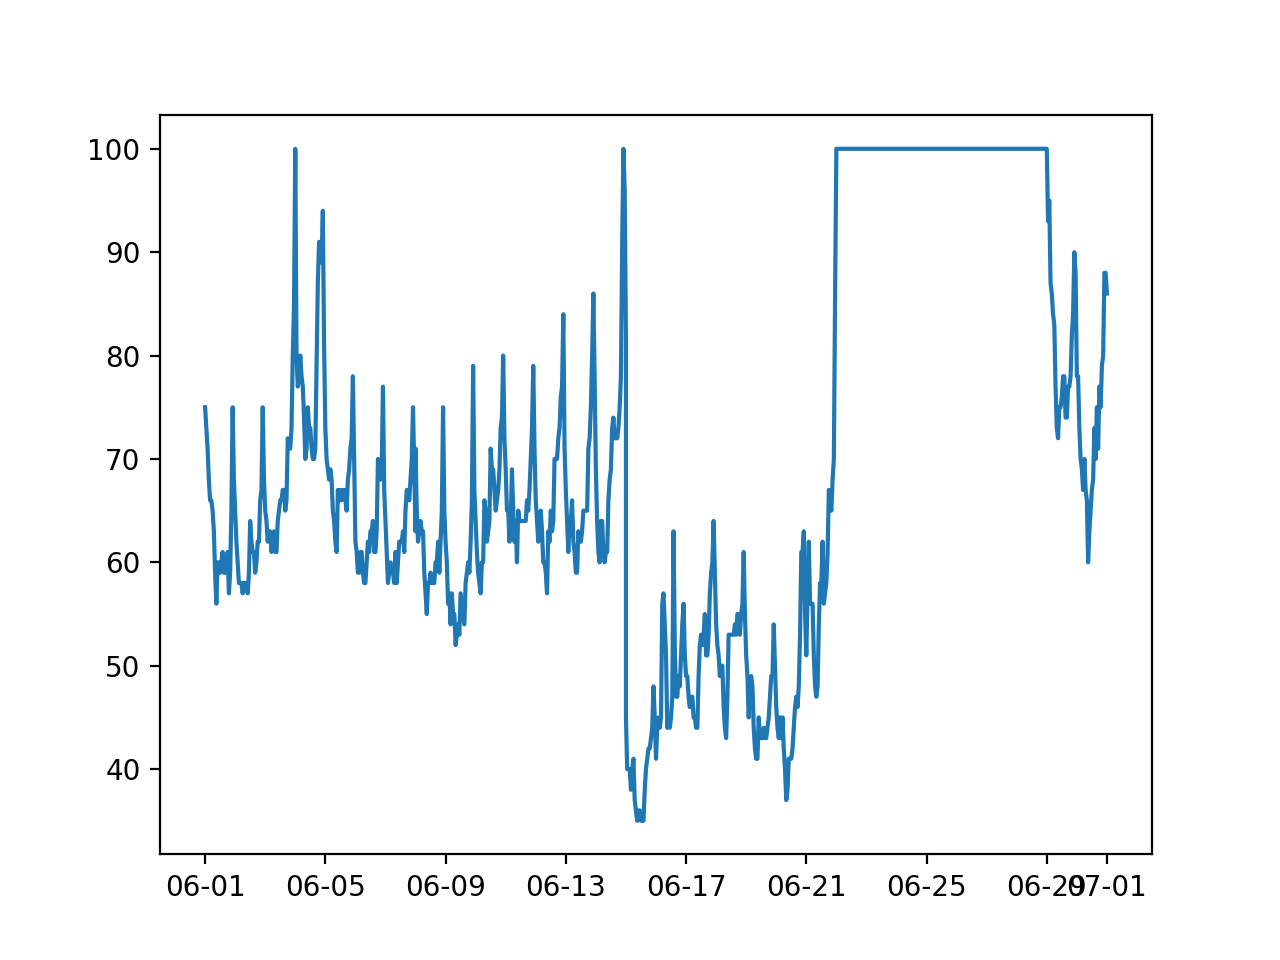

In [194]:
from pytrends.request import TrendReq

trends = TrendReq(hl='en-US', tz=0) # tz is timezone offset from UTC in minutes

'''
From trends.google.com: 

Numbers represent search interest relative to the highest point on the chart for the given region and time. 
A value of 100 is the peak popularity for the term. 
A value of 50 means that the term is half as popular. 
A score of 0 means there was not enough data for this term.
'''
bitcoinTrends = trends.get_historical_interest(["Bitcoin"], 
                                               year_start=2019, month_start=6, day_start=1, hour_start=0, 
                                               year_end=2019, month_end=7, day_end=1, hour_end=0, 
                                               cat=0, geo='', gprop='', sleep=0)

dates = [date for date, val in bitcoinTrends['Bitcoin'].items()]
vals = [val for val in bitcoinTrends['Bitcoin']]

plotTimeSeries({"Trends": {'x': dates, 'y': vals}}, dateFormat="%Y-%m-%d %H:%M:%S", graphDateFormatType="%m-%d")

# Fundamental Analysis

In [129]:
COIN_METRICS_API_PREFIX = "https://community-api.coinmetrics.io/v2/"
NETWORK_METRIC_SUFFIX = "assets/%s/metricdata?metrics="
BITCOIN_ASSET_ID = "btc"
DAILY_ADDR_METRIC_ID = "AdrActCnt"

from enum import Enum

class CoinMetricsData(Enum):
    BLOCK_COUNT = "BlkCnt"
    MARKET_CAP = "CapRealUSD"
    PRICE_USD = "PriceUSD"
    TRANSACTION_CNT = "TxCnt"
    DAILY_ADDRESSES = "AdrActCnt"
    
def getCoinMetricsDict(*keywords):
    desiredMetrics = COIN_METRICS_API_PREFIX + NETWORK_METRIC_SUFFIX % BITCOIN_ASSET_ID
    for keyword in keywords:
        desiredMetrics += keyword.value + ","
    desiredMetrics = desiredMetrics[:-1] # remove final comma
    
    return json.loads(getPageContent(desiredMetrics))['metricData']
    
#getCoinMetricsDict(CoinMetricsData.BLOCK_COUNT, CoinMetricsData.MARKET_CAP, CoinMetricsData.PRICE_USD)

## Retrieve unique address count on a given day using CoinMetrics

In [140]:
def getCoinMetricsData(desiredData, month, day, year):
    dataDict = getCoinMetricsDict(desiredData)
    
    timestampFormatted = "%04d-%02d-%02d" % (year, month, day)

    return [singleDay['values'][0] for singleDay in dataDict['series'] 
            if timestampFormatted in singleDay['time']][0]
print(getCoinMetricsData(CoinMetricsData.DAILY_ADDRESSES, 6, 28, 2019))

1008973.0


## Plot Bitcoin network data over time to understand behavior

<IPython.core.display.Javascript object>


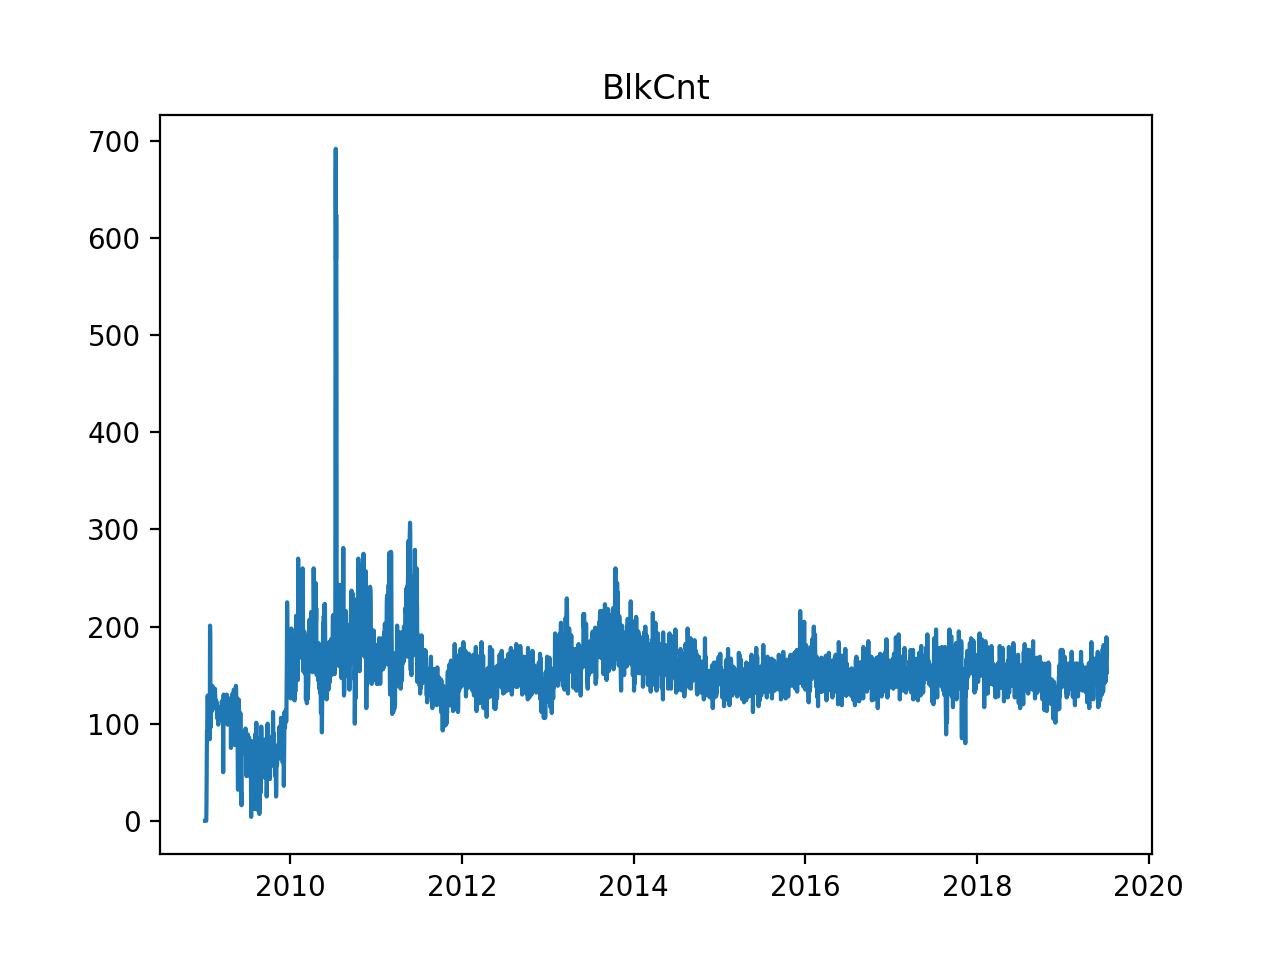

<IPython.core.display.Javascript object>


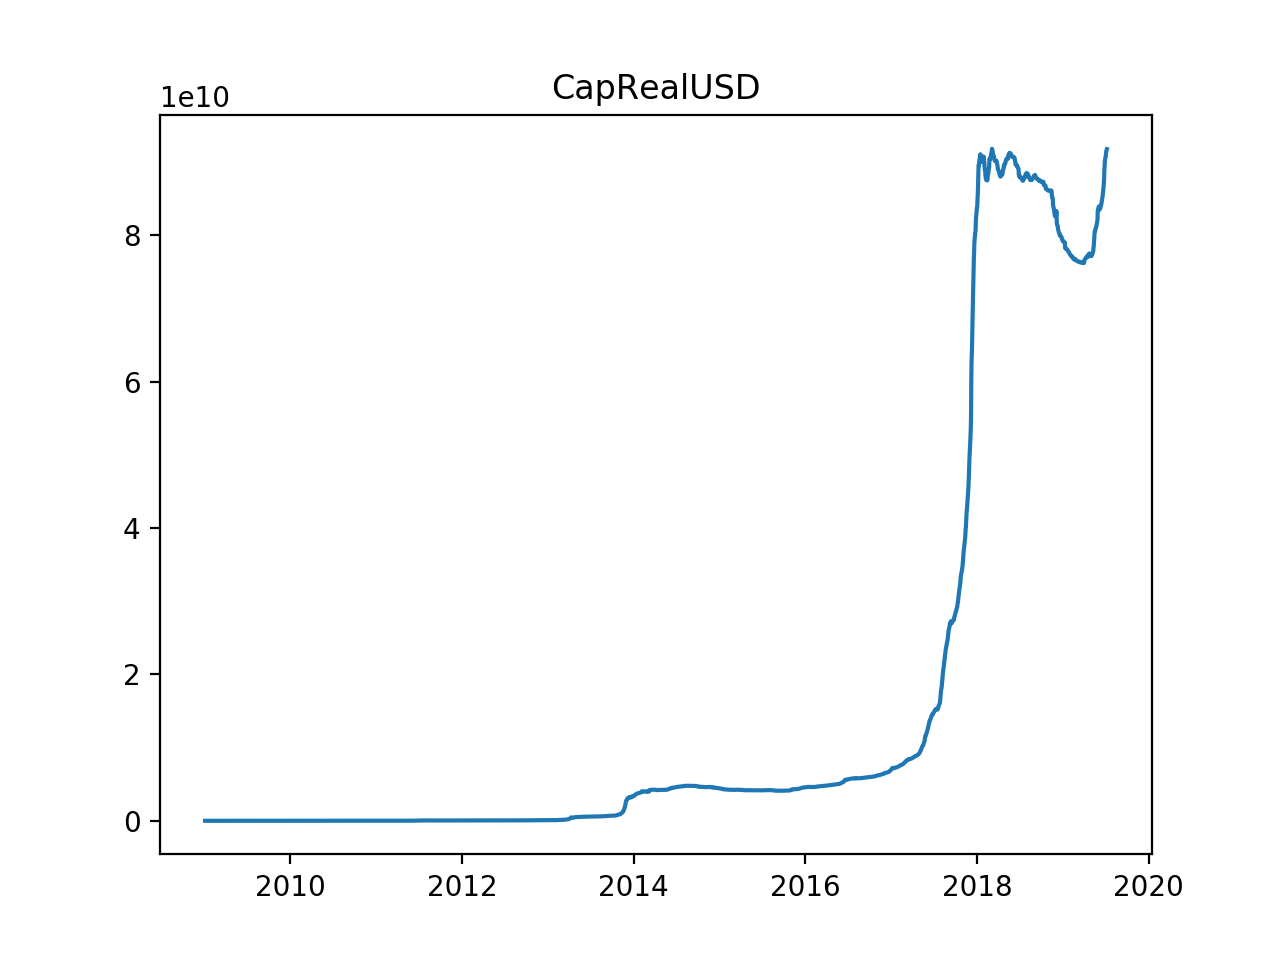

<IPython.core.display.Javascript object>


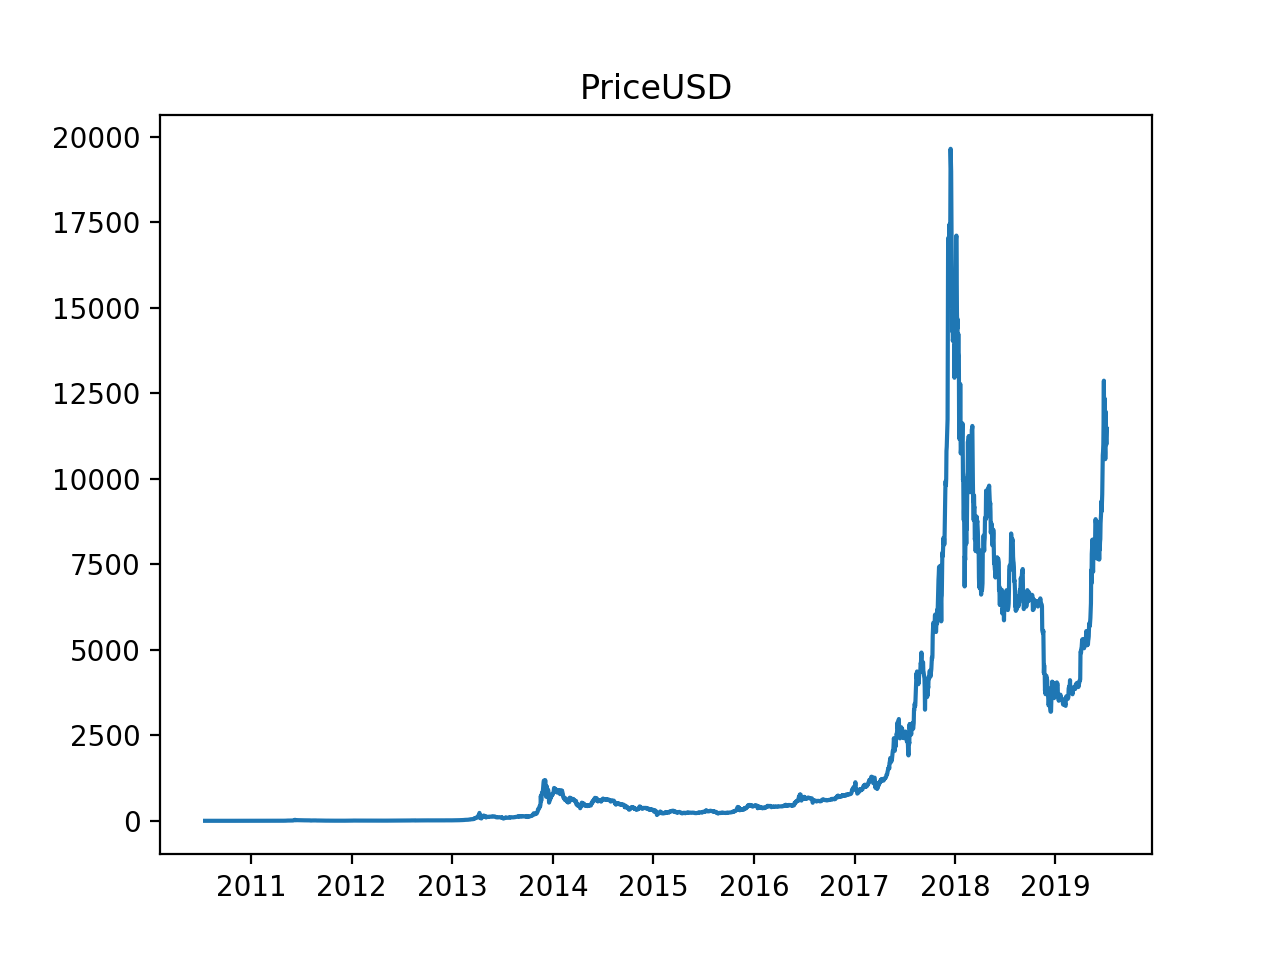

<IPython.core.display.Javascript object>


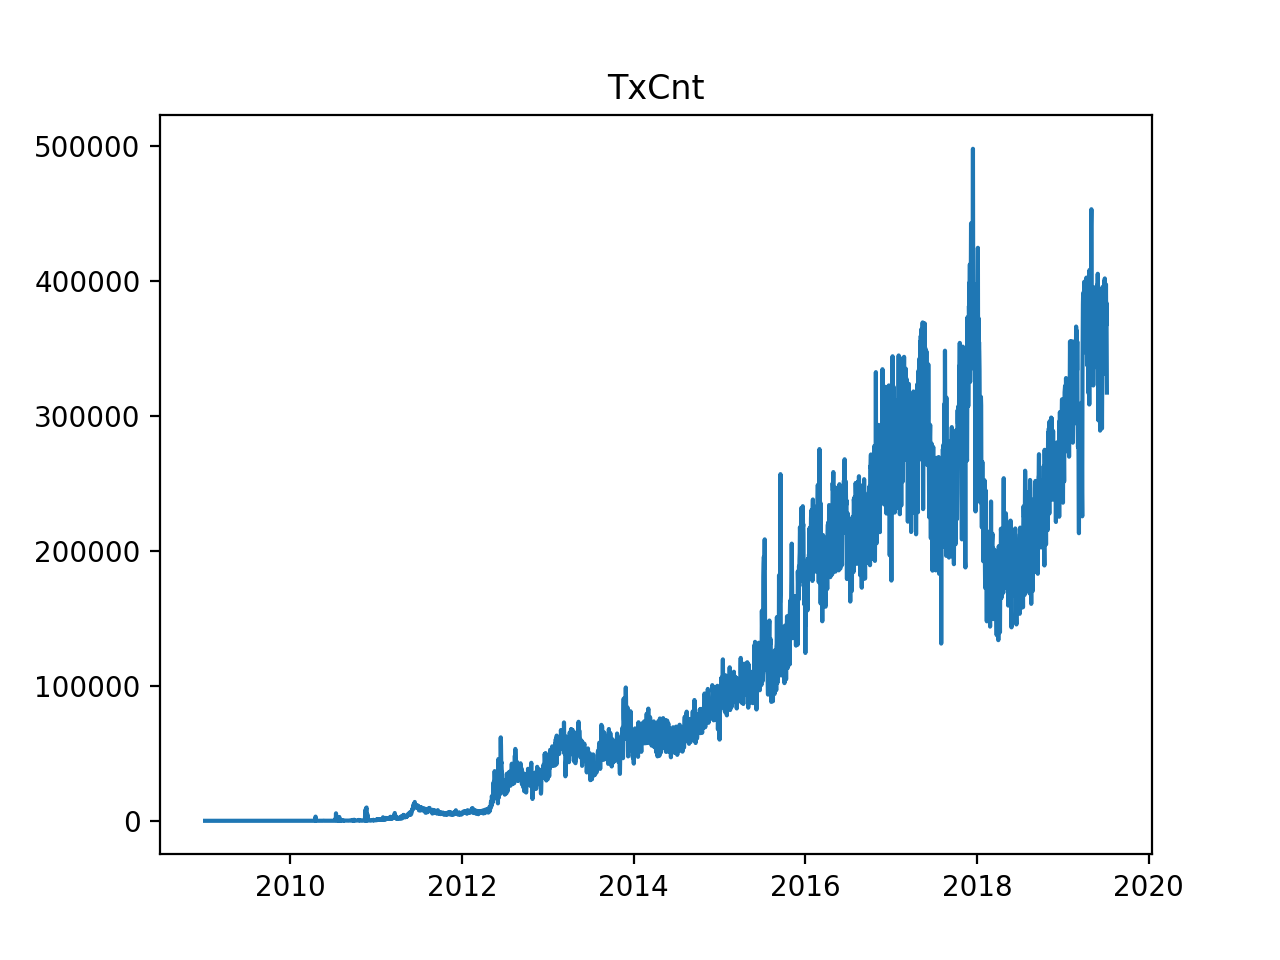

<IPython.core.display.Javascript object>


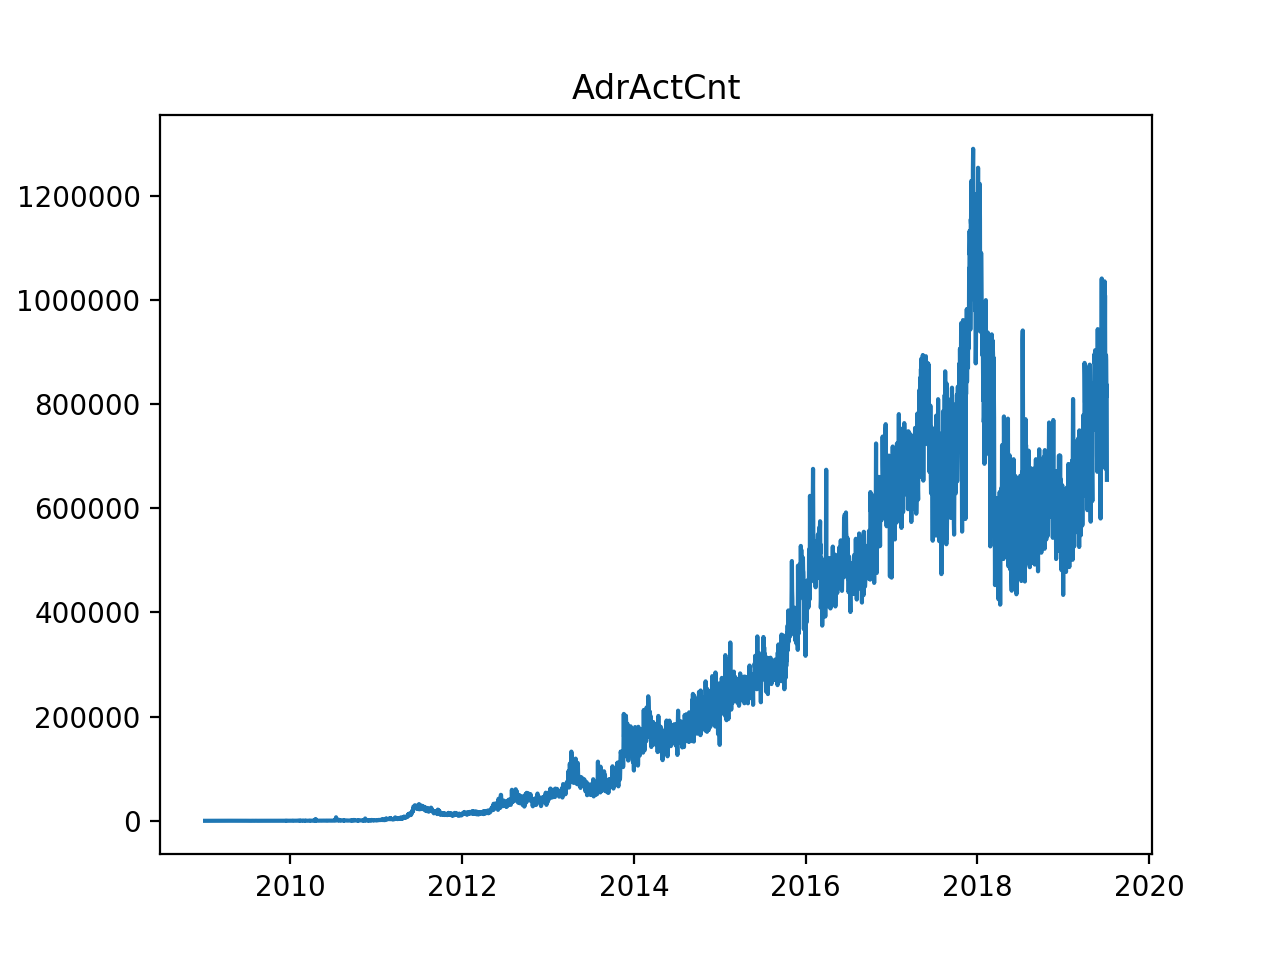

In [185]:
import datetime

def getAllCoinMetricsData(desiredData):
    data = getCoinMetricsDict(desiredData)['series']
    return ([singleDay['time'] for singleDay in data], 
            [float(singleDay['values'][0]) for singleDay in data])

for data in list(CoinMetricsData):
    dates, vals = getAllCoinMetricsData(data)
    
    plotTimeSeries({data: {'x':dates, 'y': vals}}, title=data.value)

# Aggregate Analysis

<IPython.core.display.Javascript object>


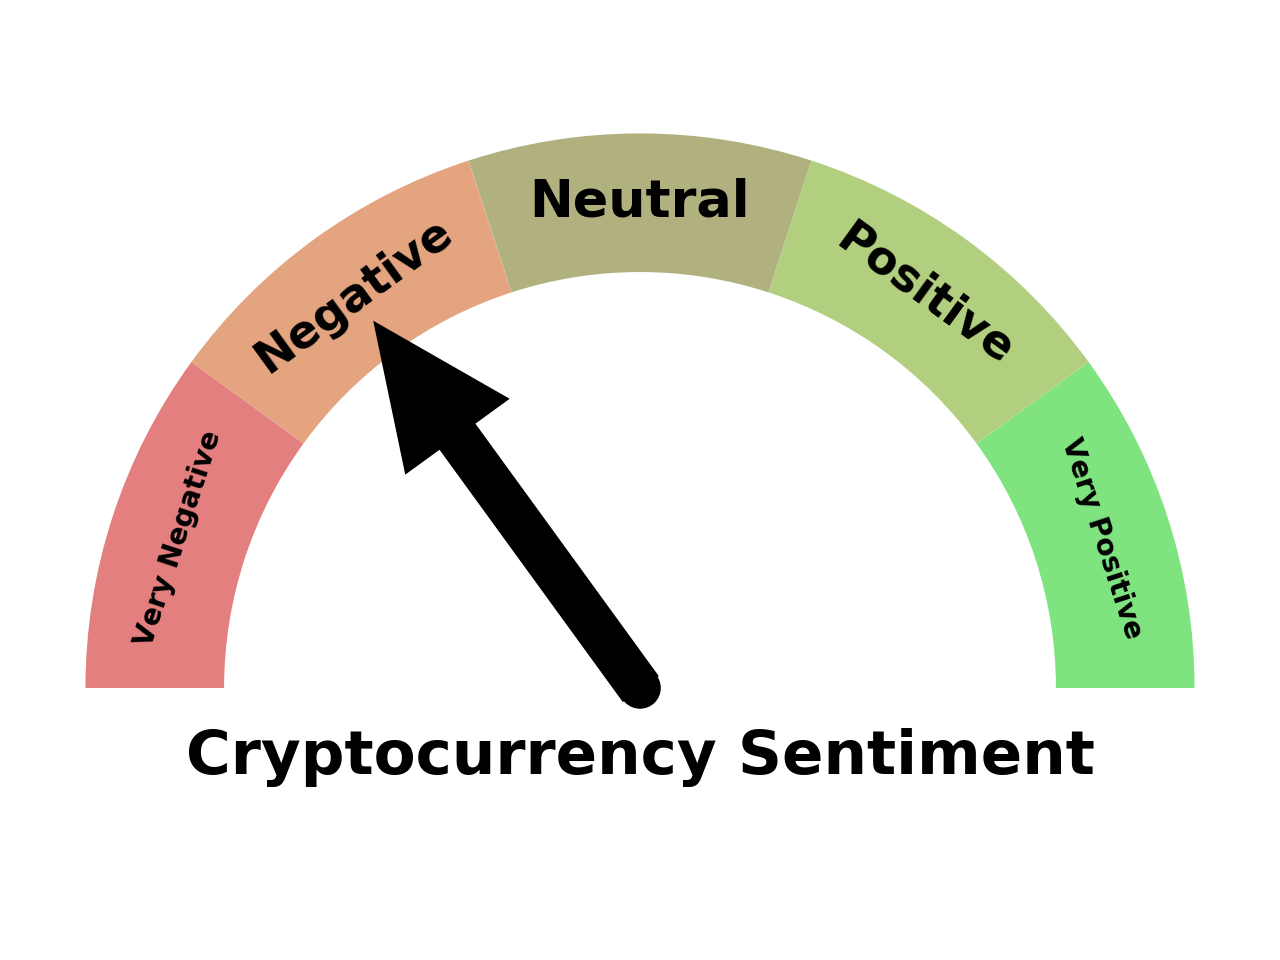

<IPython.core.display.Javascript object>


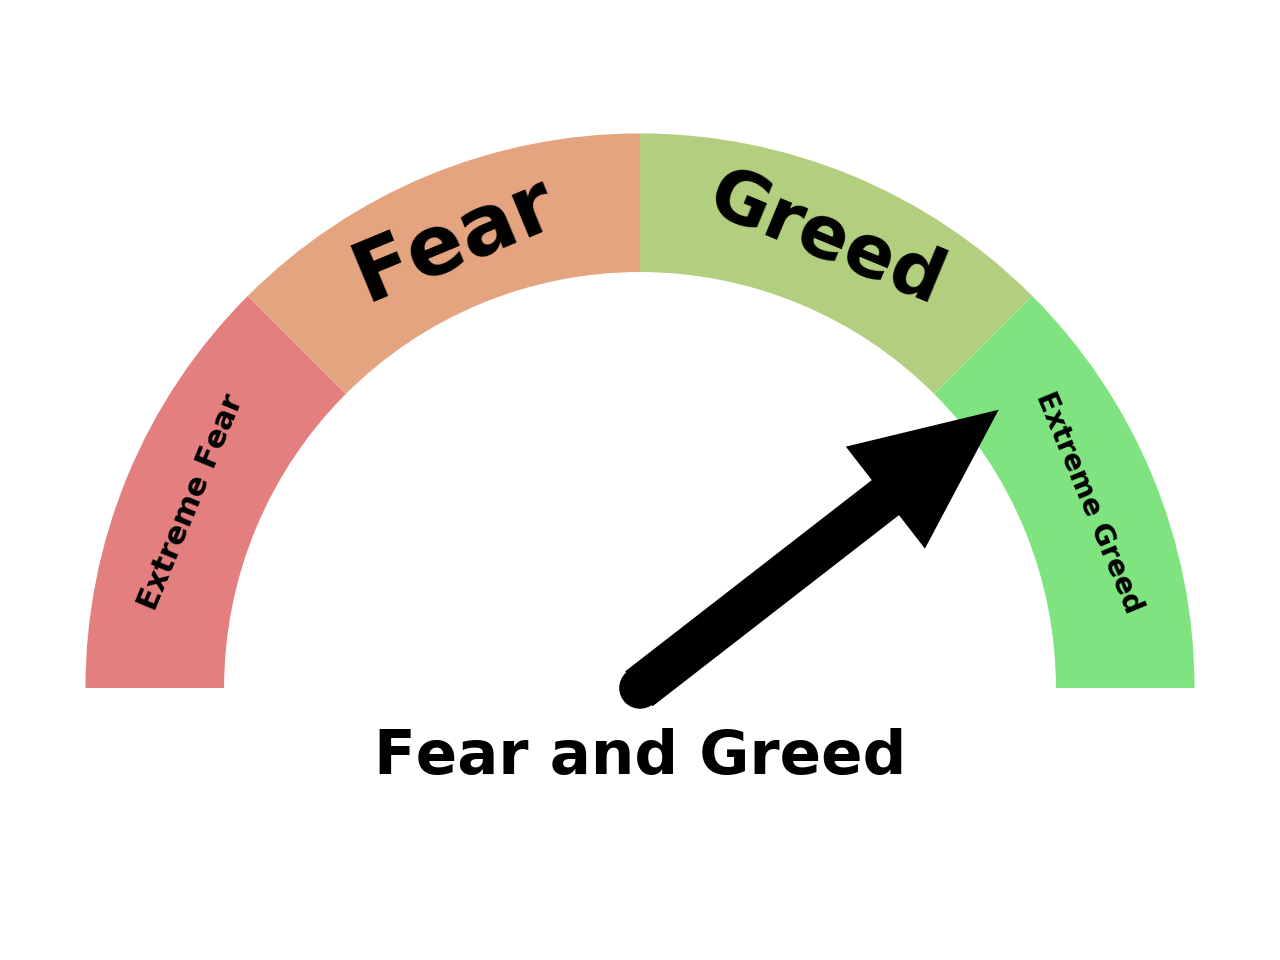

<IPython.core.display.Javascript object>


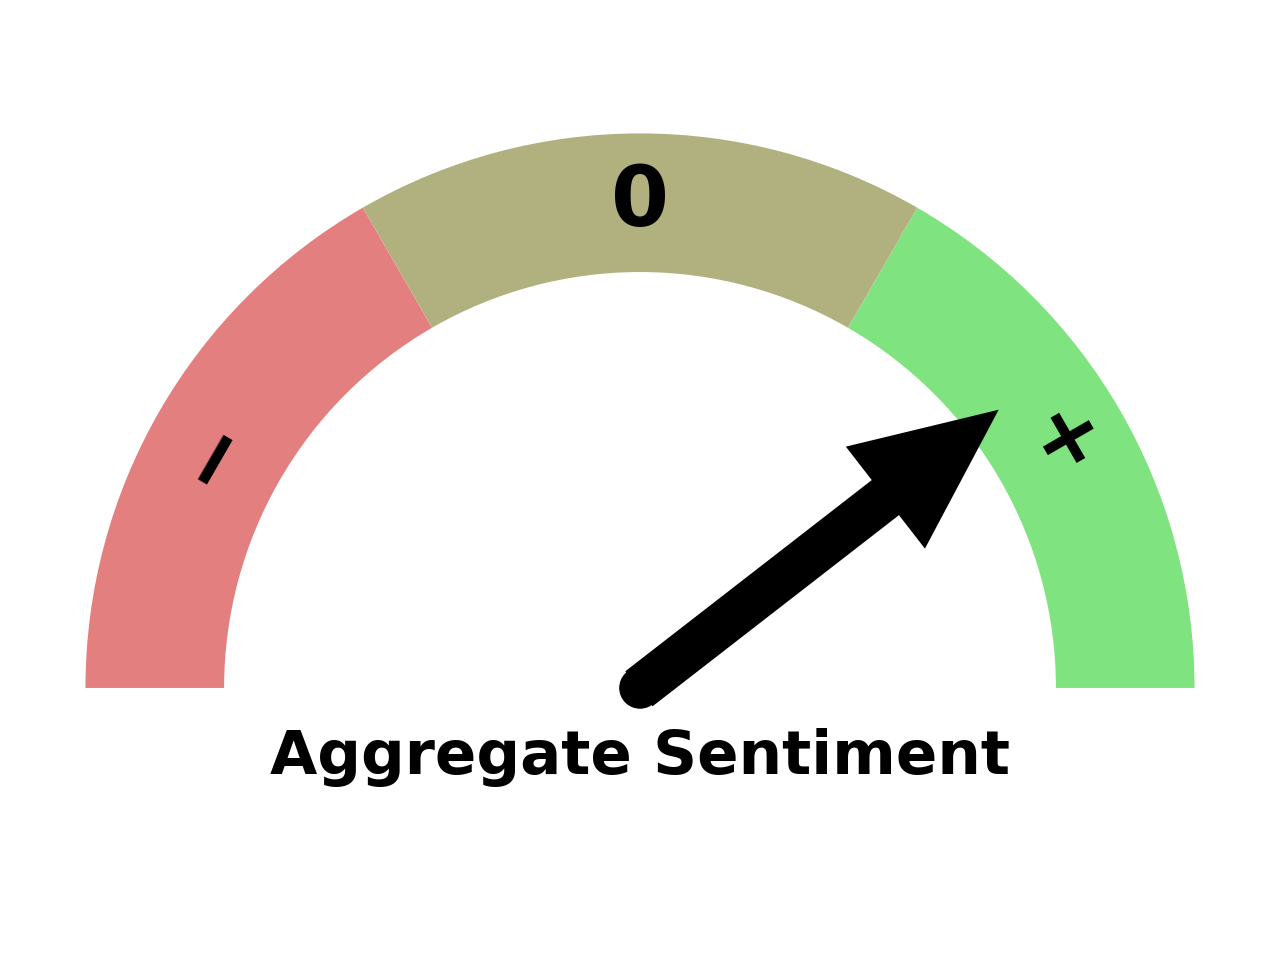

In [155]:
import ipywidgets as widgets
from IPython.display import display

def generateDisplayBox(valueDict):
    leftBoxElements = [widgets.Label(data.slider.description) for valueType, data in valueDict.items()]
    rightBoxElements = [data.slider.obj for valueType, data in valueDict.items()]
    return widgets.HBox([widgets.VBox(leftBoxElements), widgets.VBox(rightBoxElements)])

# Computes the aggregate sentiment based on a dictionary of values where a given value corresponds to a dictionary containing 
# the value's weight (with key 'weight'), the minimum possible value the value can take on (with key 'minVal'), and the 
# maximum possible value the value can take on (with key 'maxVal').
#
# Returns a tuple containing (in the following order) the aggregate value, the minimum value for this aggregate, 
# and the maximum value for this aggregate.
def computeAggregateSentiment(valueDict):
    aggregateVal = 0
    minVal = 0
    maxVal = 1
    for valueType, data in valueDict.items():
        weight = data.slider.getReading()
        scaledValue = map(data.value, data.minVal, data.maxVal, 0, 1)
        aggregateVal += scaledValue * weight
        
    return (aggregateVal, minVal, maxVal)

# Displays the aggregate sentiment meter based on a dictionary of values. See computeAggregateSentiment for a complete
# description of this parameter.
def displayAggregateSentimentMeter(valueDict):
    aggregateVal, minVal, maxVal = computeAggregateSentiment(valueDict)
    
    return gauge(labels=['—','0','+'], 
                 colors=['#c80000', '#646400', '#00c800'], currentVal=aggregateVal, 
                 minVal = minVal,
                 maxVal = maxVal, title='Aggregate Sentiment')

def updateGauge(valueDict):
    aggregateVal, minVal, maxVal = computeAggregateSentiment(valueDict)
    
    global gaugeArrow
    gaugeArrow.remove()
    highestAngle = 180
    lowestAngle = 0
    pos = map(aggregateVal, minVal, maxVal, highestAngle, lowestAngle)
    gaugeArrow = gaugeAxes.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
        width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
    fig.canvas.draw_idle()
    
def sliderEdited(change):
    sliders = {data.slider.obj:data.slider for valueType, data in valueDict.items()}
    editedSlider = change.owner
    deltaVal = change.new - change.old
    diffPerSlider = deltaVal / (len(sliders) - 1)
    
    isEditingAnything = False
    for s, sliderProperties in sliders.items():
        isEditingAnything = isEditingAnything or sliderProperties.editedManually # determine whether any value in the sliders dictionary is True
        
    # If the user manually edited a different slider, then this function should exit early because it was triggered
    # by the programmatic editing of this slider. Prevents a recursive loop.
    if isEditingAnything:
        return False

    sliders[editedSlider].editedManually = True
    
    i = 0
    
    uneditedSliders = dict(sliders)
    uneditedSliders.pop(editedSlider)
    
    # Sort the sliders by the amount of distance they can move (the one with the greatest distance should be edited first).
    # If the edited slider was decreased, all the other sliders have to move up, so the one closest to 0.0 should come last.
    # If the edited slider was increased, all the other sliders have to move down, so the one closest to 1.0 should come last. 
    if deltaVal < 0:
        sortedSliders = sorted(uneditedSliders.items(), key = lambda kv: -kv[0].value)
    else:
        sortedSliders = sorted(uneditedSliders.items(), key = lambda kv: kv[0].value - MAX_VAL)
    
    for s, editing in sortedSliders:
        origVal = s.value
        s.value = max(0, s.value - diffPerSlider)
        
        # Only subtracts off the difference which was calculated in the slider (useful when the difference brings the
        # slider value to a number less than zero).
        deltaVal -= (origVal - s.value)
        if i != (len(sortedSliders) - 1): # avoid unnecessary division by zero on the last iteration (value will not be used again)
            diffPerSlider = deltaVal / (len(sortedSliders) - i - 1)
        i += 1
    
    # Reset that a value was edited manually to ensure other sliders can trigger this function.
    sliders[editedSlider].editedManually = False
    updateGauge(valueDict)
    
MAX_VAL = 1.0
STEP = 0.01

sentiment, sentimentGauge = displaySentimentTxt(getCNNText("https://www.cnn.com/2019/06/21/investing/bitcoin-price-increase/index.html"))
fearAndGreed, fngGauge = displayFearAndGreedDate(7, 3, 2019)

class Slider:
    def __init__(self, obj, editedManually, description):
        self.obj = obj
        self.editedManually = editedManually
        self.description = description
        
    def getReading(self):
        return self.obj.value
    
    def setReading(self, newReading):
        self.obj.value = newReading
    
class DataReading:
    def __init__(self, value, minVal, maxVal, slider):
        self.value = value
        self.slider = slider
        self.minVal = minVal
        self.maxVal = maxVal
        
    def initSliderValue(self, numSliders):
        self.slider.setReading(MAX_VAL / numSliders)
        self.slider.obj.observe(sliderEdited, 'value')
        

valueDict = {'sentiment': DataReading(value=sentiment, minVal=MIN_SENTIMENT, maxVal = MAX_SENTIMENT,
                                      slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                    editedManually=False,
                                                    description="NLP Weight")),
             'fearAndGreed': DataReading(value=fearAndGreed, minVal=MIN_FEAR_AND_GREED, maxVal=MAX_FEAR_AND_GREED,
                                         slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
                                                      description="Fear and Greed Weight"))}

for valueType, data in valueDict.items():
    data.initSliderValue(len(valueDict))

gaugeArrow, gaugeAxes, fig = displayAggregateSentimentMeter(valueDict)
display(generateDisplayBox(valueDict))

# Wrap-Up

In [ ]:
exec('kill $(lsof -ti tcp:9000)')